<strong>Step1: Brief description of the problem and data (5 pts)</strong></br>
<strong>Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data. </strong>

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
print(len(os.listdir('/hpctmp/e0427773/histopathologic-cancer-detection/train/')))
print(len(os.listdir('/hpctmp/e0427773/histopathologic-cancer-detection/test/')))

220025
57458


<strong>There are 220,025 training samples and 57,458 test samples

In [2]:
train_labels = pd.read_csv('/hpctmp/e0427773/histopathologic-cancer-detection/train_labels.csv', dtype=str)
print(train_labels.shape)

(220025, 2)


In [3]:
train_labels['label'] = train_labels['label'].astype(float)
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0.0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1.0
2,755db6279dae599ebb4d39a9123cce439965282d,0.0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0.0
4,068aba587a4950175d04c680d38943fd488d6a9d,0.0


<strong>Step2: Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)</strong></br>
<strong>Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis?</strong>

In [4]:
train_labels['label'].value_counts()

0.0    130908
1.0     89117
Name: label, dtype: int64

<AxesSubplot:ylabel='label'>

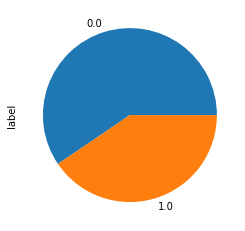

In [16]:
train_labels['label'].value_counts().plot(kind='pie')

<strong>There are 130,908 non-cancer images and 89,117 cancer images in the training samples

In [5]:
train_labels_pos = train_labels[train_labels['label']==1]
train_labels_neg = train_labels[train_labels['label']==0]

In [6]:
train_labels_neg = train_labels_neg.sample(n = train_labels_pos.shape[0])

In [7]:
train_labels_equal = pd.concat([train_labels_neg,train_labels_pos]).sample(frac=1, random_state=17).reset_index(drop=True)
train_labels_equal.shape

(178234, 2)

<AxesSubplot:ylabel='label'>

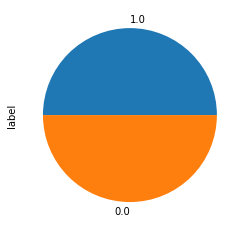

In [14]:
train_labels_equal['label'].value_counts().plot(kind='pie')

<strong>A balanced dataset was created by combining equal numbers of cancer (pos) and non-cancer (neg) images

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [9]:
from PIL import Image

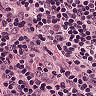

(96, 96)


In [10]:
with Image.open('/hpctmp/e0427773/histopathologic-cancer-detection/train/7ff2b0252621ce92abe5cad8afdf331c7000612a.tif') as im:
    im.show()
    print(im.size)

<strong>A sample image is shown here and the size is 96 pixels in height and 96 pixels in width

<strong>Step3: Model Architecture (25 pts)</br>
Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters. 

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
train_img, valid_img = train_test_split(train_labels_equal, test_size=0.25,
                                        random_state=1710, stratify=train_labels_equal.label)

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.layers import PReLU
from keras.initializers import Constant
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [14]:
train_img['id'] = train_img['id']+'.tif'
valid_img['id'] = valid_img['id']+'.tif'

In [15]:
train_img['label'] = train_img['label'].astype(str)
valid_img['label'] = valid_img['label'].astype(str)

<strong>The codes below were uploaded and run on HPC due to the limited computational resource of the local machine

<strong>First I'd like to try a model with four hidden layers. Each hidden layer has two convolutional neural networks and one max pooling layer.

In [ ]:
train_datagen=ImageDataGenerator(rescale=1/255)

train_gen=train_datagen.flow_from_dataframe(dataframe=train_img,directory="/hpctmp/e0427773/histopathologic-cancer-detection/train/",
                x_col="id",y_col="label",batch_size=64,seed=1710,shuffle=True,
                class_mode="binary",target_size=(96,96))

valid_gen=train_datagen.flow_from_dataframe(dataframe=valid_img,directory="/hpctmp/e0427773/histopathologic-cancer-detection/train/",
                x_col="id",y_col="label",batch_size=64,seed=1710,shuffle=True,
                class_mode="binary",target_size=(96,96))

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=(96,96,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
          
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dropout(0.25))
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.25))
model.add(Dense(64))
model.add(Activation('relu')) 

model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

hist_df = pd.DataFrame(history.history) 
with open('history.csv', mode='w') as f:
    hist_df.to_csv(f)

<strong>Then I'd like to increase the complexity of each hidden layer but reduce the total number of hidden layers.

In [ ]:
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), padding='same',input_shape=(96,96,3)))
model2.add(Activation('relu'))
model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())

model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())

model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())
          
model2.add(Flatten())
model2.add(Dropout(0.25))
model2.add(Dense(256))
model2.add(Activation('relu'))

model2.add(Dropout(0.25))
model2.add(Dense(128))
model2.add(Activation('relu'))

model2.add(Dropout(0.25))
model2.add(Dense(64))
model2.add(Activation('relu')) 

model2.add(Dropout(0.25))
model2.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(0.001)
model2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model2.summary()

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history2 = model2.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=30, verbose=1
)

hist2_df = pd.DataFrame(history2.history) 
with open('history2.csv', mode='w') as f:
    hist2_df.to_csv(f)


<strong>Step4: Results and Analysis (35 pts)</br>
Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.
Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

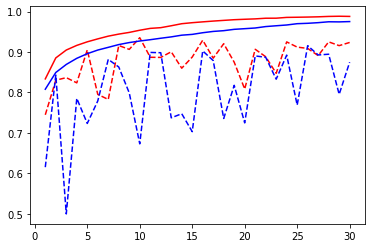

In [ ]:
plt.plot(hist1.index+1, hist1['accuracy'], color='red')
plt.plot(hist1.index+1, hist1['val_accuracy'], color='red', linestyle='dashed')
plt.plot(hist2.index+1, hist2['accuracy'], color='blue')
plt.plot(hist2.index+1, hist2['val_accuracy'], color='blue', linestyle='dashed')

<strong>Model 1 outperformed model 2 regarding the accuracy

<strong>Strp5: Conclusion (15 pts)</br>
Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

<strong>Various problems require different complexity of the model. Always try different numbers of hidden layers and different numbers of convolutional layers within each hidden layer. Meanwhile, it is important to have a balanced dataset for training.

In [ ]:
test_set = os.listdir('/hpctmp/e0427773/histopathologic-cancer-detection/test/')
test_df = pd.DataFrame(test_set)
test_df.columns = ['id']
test_datagen=ImageDataGenerator(rescale=1/255)

test_generator=test_datagen.flow_from_dataframe(dataframe=test_df, directory="/hpctmp/e0427773/histopathologic-cancer-detection/test/",x_col="id",batch_size=64,seed=1710,shuffle=False,class_mode=None,target_size=(96,96))

STEP_SIZE_TEST=test_generator.n//test_generator.batch_size + 1

preds = model.predict_generator(generator=test_generator,steps=STEP_SIZE_TEST, verbose = 1)

predictions = []
for pred in preds:
    if pred >= 0.5:
        predictions.append(1)
    else:
        predictions.append(0)

submission = test_df.copy()
submission['id'] = list(map(lambda x: x[:-4], submission['id']))
submission['label']=predictions
submission.to_csv('submission.csv',index=False)